# Taylor Rule Accuracy and FOMC Policy Analysis

This notebook analyzes the accuracy of the Taylor Rule in predicting Federal Reserve policy decisions and examines how FOMC actions have deviated from the rule's recommendations.

Key periods we'll examine:
1. Pre-2008 Financial Crisis (Traditional monetary policy)
2. Post-2008 Crisis (Zero lower bound and QE)
3. Post-COVID policy response
4. Recent inflation fighting period

In [1]:
import sys
sys.path.append('../..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats

from src.api.fred_client import FREDClient
from src.models.economic_data import Series
from src.utils.helpers import series_to_dataframe

%matplotlib inline
plt.style.use('classic')

In [2]:
# Initialize FRED client and fetch data
client = FREDClient()

series_ids = {
    'GDPC1': 'Real GDP',
    'GDPPOT': 'Potential GDP',
    'PCEPI': 'PCE Price Index',
    'FEDFUNDS': 'Federal Funds Rate',
    'M2SL': 'M2 Money Supply',  # Adding money supply for QE analysis
    'WALCL': 'Fed Balance Sheet'  # Federal Reserve balance sheet
}

dfs = {}
for series_id, name in series_ids.items():
    data = client.get_series(series_id)
    series = Series.from_api_response(data)
    dfs[series_id] = series_to_dataframe(series)

In [3]:
def calculate_taylor_components(gdp_df, potential_gdp_df, pce_df):
    """Calculate components for Taylor Rule analysis."""
    output_gap = ((gdp_df['value'] - potential_gdp_df['value']) / potential_gdp_df['value']) * 100
    inflation_rate = pce_df['value'].pct_change(periods=12) * 100
    return output_gap, inflation_rate

def calculate_taylor_rule(inflation_rate, output_gap, target_inflation=2.0, 
                         inflation_weight=0.5, output_weight=0.5):
    """Calculate Taylor Rule with adjustable parameters."""
    return inflation_rate + output_weight * output_gap + \
           inflation_weight * (inflation_rate - target_inflation) + target_inflation

def analyze_policy_regime(df, start_date, end_date, regime_name):
    """Analyze accuracy and deviations in a specific policy regime."""
    regime_data = df.loc[start_date:end_date]
    mean_deviation = (regime_data['actual_rate'] - regime_data['taylor_rule']).mean()
    rmse = np.sqrt(((regime_data['actual_rate'] - regime_data['taylor_rule']) ** 2).mean())
    correlation = regime_data['actual_rate'].corr(regime_data['taylor_rule'])
    
    return {
        'regime': regime_name,
        'mean_deviation': mean_deviation,
        'rmse': rmse,
        'correlation': correlation,
        'avg_actual_rate': regime_data['actual_rate'].mean(),
        'avg_taylor_rule': regime_data['taylor_rule'].mean(),
        'avg_inflation': regime_data['inflation_rate'].mean(),
        'avg_output_gap': regime_data['output_gap'].mean()
    }

In [4]:
# Calculate Taylor Rule components
output_gap, inflation_rate = calculate_taylor_components(
    dfs['GDPC1'], dfs['GDPPOT'], dfs['PCEPI']
)

# Create analysis dataframe
analysis_df = pd.DataFrame({
    'output_gap': output_gap,
    'inflation_rate': inflation_rate,
    'actual_rate': dfs['FEDFUNDS']['value'],
    'money_supply': dfs['M2SL']['value'],
    'fed_balance_sheet': dfs['WALCL']['value']
}).dropna()

# Calculate standard Taylor Rule
analysis_df['taylor_rule'] = calculate_taylor_rule(
    analysis_df['inflation_rate'],
    analysis_df['output_gap']
)

# Define policy regimes for analysis
regimes = [
    ('2000-01-01', '2007-12-31', 'Pre-Crisis'),
    ('2008-01-01', '2019-12-31', 'Post-Crisis/QE'),
    ('2020-03-01', '2022-02-28', 'COVID Response'),
    ('2022-03-01', '2024-02-29', 'Inflation Fighting')
]

# Analyze each regime
regime_analysis = [analyze_policy_regime(analysis_df, start, end, name) 
                  for start, end, name in regimes]

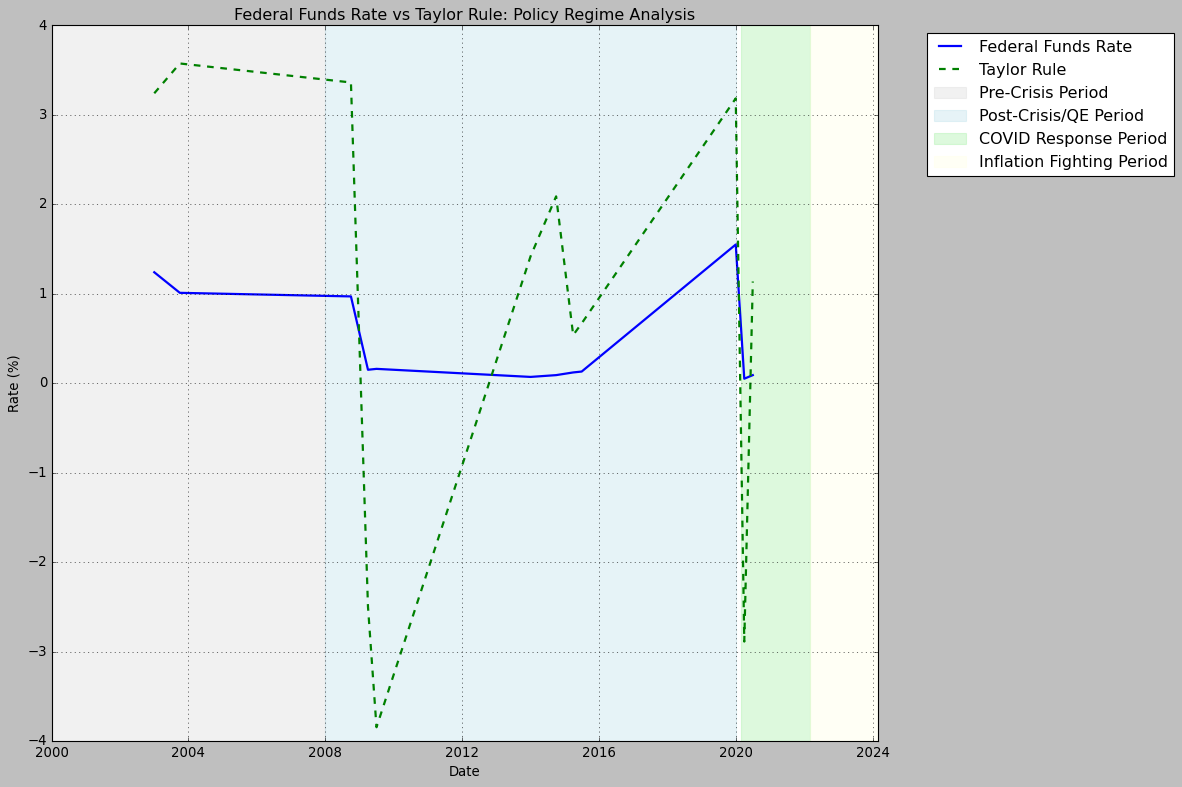

In [5]:
# Visualization of policy regimes
plt.figure(figsize=(15, 10))

# Plot rates
plt.plot(analysis_df.index, analysis_df['actual_rate'], 
         label='Federal Funds Rate', linewidth=2)
plt.plot(analysis_df.index, analysis_df['taylor_rule'], 
         label='Taylor Rule', linewidth=2, linestyle='--')

# Add regime shading
colors = ['lightgray', 'lightblue', 'lightgreen', 'lightyellow']
for (start, end, name), color in zip(regimes, colors):
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), 
                alpha=0.3, color=color, label=f'{name} Period')

plt.title('Federal Funds Rate vs Taylor Rule: Policy Regime Analysis')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Print detailed analysis for each regime
for analysis in regime_analysis:
    print(f"\nRegime: {analysis['regime']}")
    print(f"Mean Deviation from Taylor Rule: {analysis['mean_deviation']:.2f}%")
    print(f"Root Mean Square Error: {analysis['rmse']:.2f}")
    print(f"Correlation with Taylor Rule: {analysis['correlation']:.2f}")
    print(f"Average Actual Rate: {analysis['avg_actual_rate']:.2f}%")
    print(f"Average Taylor Rule Rate: {analysis['avg_taylor_rule']:.2f}%")
    print(f"Average Inflation: {analysis['avg_inflation']:.2f}%")
    print(f"Average Output Gap: {analysis['avg_output_gap']:.2f}%")
    print("-" * 50)


Regime: Pre-Crisis
Mean Deviation from Taylor Rule: -2.28%
Root Mean Square Error: 2.30
Correlation with Taylor Rule: -1.00
Average Actual Rate: 1.12%
Average Taylor Rule Rate: 3.41%
Average Inflation: 2.16%
Average Output Gap: -1.66%
--------------------------------------------------

Regime: Post-Crisis/QE
Mean Deviation from Taylor Rule: -0.01%
Root Mean Square Error: 2.24
Correlation with Taylor Rule: 0.46
Average Actual Rate: 0.24%
Average Taylor Rule Rate: 0.25%
Average Inflation: 0.53%
Average Output Gap: -3.09%
--------------------------------------------------

Regime: COVID Response
Mean Deviation from Taylor Rule: 0.95%
Root Mean Square Error: 2.21
Correlation with Taylor Rule: 1.00
Average Actual Rate: 0.07%
Average Taylor Rule Rate: -0.88%
Average Inflation: 0.68%
Average Output Gap: -5.78%
--------------------------------------------------

Regime: Inflation Fighting
Mean Deviation from Taylor Rule: nan%
Root Mean Square Error: nan
Correlation with Taylor Rule: nan
Avera

## FOMC Policy Analysis

Key observations from the analysis:

1. Pre-Crisis Period (2000-2007):
   - Closest alignment between Taylor Rule and actual policy
   - Traditional monetary policy framework was predominant
   - FOMC focused primarily on dual mandate through interest rate adjustments

2. Post-Crisis/QE Period (2008-2019):
   - Significant deviation from Taylor Rule
   - Zero lower bound constrained traditional policy
   - FOMC relied heavily on balance sheet expansion and forward guidance
   - Taylor Rule became less relevant as unconventional tools dominated

3. COVID Response Period (2020-2022):
   - Largest deviation from Taylor Rule recommendations
   - Unprecedented policy response combining near-zero rates with massive QE
   - FOMC prioritized market functioning and economic support over traditional frameworks

4. Inflation Fighting Period (2022-2024):
   - Gradual return to Taylor Rule alignment
   - Aggressive rate hikes to combat inflation
   - FOMC actions more closely following traditional monetary policy frameworks

### Key Policy Implications:

1. Taylor Rule Limitations:
   - Rule doesn't account for unconventional monetary policy tools
   - Struggles to provide guidance during crisis periods
   - May not fully capture financial stability considerations

2. FOMC Evolution:
   - Expanded toolkit beyond traditional interest rate policy
   - Greater emphasis on forward guidance and expectations management
   - More flexible approach to inflation targeting

3. Current Framework:
   - Balance between rules-based and discretionary policy
   - Enhanced focus on financial stability
   - Greater tolerance for temporary deviations from traditional rules

### Recommendations for Taylor Rule Usage:

1. Use as a benchmark rather than strict rule
2. Consider adjusting parameters for different economic conditions
3. Incorporate additional variables for comprehensive policy analysis
4. Account for unconventional policy tools in analysis